In [1]:

!pip install --upgrade pip
!pip install keras==2.2.4
!pip install tensorflow==1.15
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master'

import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

     |████████████████████████████████| 1.5MB 15.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 312 kB 19.2 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 412.3 MB 19 kB/s 
     |████████████████████████████████| 503 kB 51.7 MB/s 
     |████████████████████████████████| 3.8 MB 62.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=bbe11c022f548f4405522c87307cf975f20fe5f062e12fd545aa763af314e02b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalli

In [2]:
# path for the source weights file to load.

weights_source_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/VGG_coco_SSD_300x300_iter_400000.h5'

#path and name for the destination weights file to create.

weights_destination_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/VGG_coco_SSD_300x300_iter_400000_subsampled_9_classes.h5'

# copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/VGG_coco_SSD_300x300_iter_400000_subsampled_9_classes.h5'

In [6]:
# Load both the source weights file and the copy.

weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


In [7]:

#classification layers in SSD which i need to sub-sample because rest of the them are fine
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

In [8]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 324)
bias:	 (324,)


In [9]:
n_classes_source = 81
classes_of_interest = [0 ,4 , 3, 57, 2, 10, 1, 59, 12, 6]

subsampling_indices = []
for i in range(int(324/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices)

[0, 4, 3, 57, 2, 10, 1, 59, 12, 6, 81, 85, 84, 138, 83, 91, 82, 140, 93, 87, 162, 166, 165, 219, 164, 172, 163, 221, 174, 168, 243, 247, 246, 300, 245, 253, 244, 302, 255, 249]


These are the indices of the 36 elements that we want to pick from both the bias vector and from the last axis of the kernel tensor.

This was the detailed example for the '`conv4_3_norm_mbox_conf`' layer. And of course we haven't actually sub-sampled the weights for this layer yet, we have only figured out which elements we want to keep. The piece of code in the next section will perform the sub-sampling for all the classifier layers.

# SUB_SAMPLING

In [10]:

n_classes_source = 81

classes_of_interest = [0 ,4 , 3, 57, 2, 10, 1, 59, 12, 6]
# classes_of_interest = 10 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value


    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements to sub-sample.

    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    

    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

weights_destination_file.flush()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.


# Inspecting weights of my output file

In [11]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 40)
bias:	 (40,)


## Verifying my sub-sampled weights actually work

In [12]:
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.object_detection_2d_geometric_ops import Resize

Using TensorFlow backend.


###  Set the parameters for the model.

In [14]:
img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we should set this to `True`, but weirdly the results are better without swapping.
# TODO: Set the number of classes.
n_classes = 9 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets.
# scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets.
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
normalize_coords = True

### model building



In [41]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

print("Model built.")

# 2: Loaded the sub-sampled weights into the model.


weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Model built.
Weights file loaded: /content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/VGG_coco_SSD_300x300_iter_400000_subsampled_9_classes.h5


### Loading some images to test our model on


In [42]:
# dataset = DataGenerator()

# TODO: Set the paths to your dataset here.
# images_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/test/'
# test_image_set_path ='/content/gdrive/MyDrive/Final Code Fyp/ssd_keras-master/test_val.txt'
# annotations_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/test/'
# # labels_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/test_labels.csv'

# print(test_image_set_path)

dataset = DataGenerator()

# Set the paths to the dataset here.
images_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/test/'
labels_path = '/content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/new_test_labels.csv'

dataset.parse_csv(images_dir=images_path,
                  labels_filename=labels_path,
                  input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                  include_classes='all',
                  random_sample=False)

print("Number of images in the dataset:", dataset.get_dataset_size())

# dataset.parse_xml(images_dirs=images_path,
#                    annotations_dirs=annotations_path,
#                   image_set_filenames=test_image_set_path,
#                   classes=['background',
#                            'bike',
#                            'car',
#                            'Chair',
#                            'door',
#                            'dustbin',
#                            'person',
#                            'plant',
#                            'stairs',
#                            'Wall'
#                            ],
#                   include_classes = 'all',
#                   exclude_truncated=False,
#                   exclude_difficult=False)


# print("Number of images in the dataset:", dataset.get_dataset_size())

Number of images in the dataset: 972


In [43]:
convert_to_3_channels = ConvertTo3Channels()
random_max_crop = RandomMaxCropFixedAR(patch_aspect_ratio=img_width/img_height)
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              random_max_crop,
                                              resize],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

In [54]:
# Generate samples

batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /content/gdrive/My Drive/Final Code Fyp/ssd_keras-master/test/cars609.jpg

Ground truth boxes:

[[  2   3   1 299 295]]


### Making predictions and visualize them

In [60]:
# Make a prediction

y_pred = model.predict(batch_images)

In [61]:
# Decode the raw prediction.

i = 0

confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_thresh[0])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[  9.     0.97  -3.94  -6.53 293.49 299.73]]


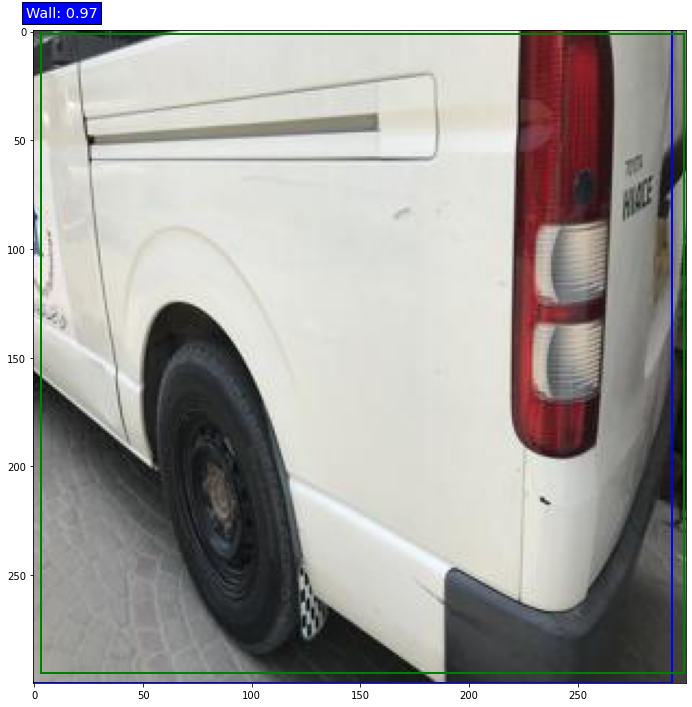

In [62]:
# Visualize the predictions.

from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

classes=['background',
                           'bike',
                           'car',
                           'Chair',
                           'door',
                           'dustbin',
                           'person',
                           'plant',
                           'stairs',
                           'Wall'
                           ] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_thresh[i]:
    class_id = box[0]
    confidence = box[1]
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    label = '{}: {:.2f}'.format(classes[int(class_id)], confidence)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    class_id = box[0]
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(class_id)])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

Seems as if our sub-sampled weights were doing a good job, sweet. Now we can fine-tune this model on our dataset with 8 classes.